## Access to the DB

### SQLite

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd
from churnmodels.schema import get_db_uri

options = {
        "dialect":"sqlite",
        "file":"../churn.db"
    }

if True:
    # connect to the database
    db_uri=get_db_uri(options, "sqlite") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    session = sessionmaker(bind=engine)()

    # we get the log function from an extension library for sqlite
    from sqlalchemy import event
    @event.listens_for(engine, "connect")
    def connect(dbapi_connection, connection_rec):
        dbapi_connection.enable_load_extension(True)
        dbapi_connection.execute('SELECT load_extension("libsqlitefunctions")')


### PostGres

In [1]:
import os
import sqlalchemy as sa
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd
from churnmodels.schema import get_db_uri

options = {
        "dialect":"postgresql",
        "user": "postgres",
           "pass": "password",
           "dbname": "churn",
           "schema": "biznet1"
           #"host" : "localhost" # ...if needed
           #"port" : "5432" # ...if needed
           }

if True:
    # connect to the database
    db_uri=get_db_uri(options, "postgres") # "postgres" names the dialect we are using
    engine=create_engine(db_uri)
    engine.dialect.has_schema(engine, options["schema"]) 
    session = sessionmaker(bind=engine)()


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sqlalchemy import func, or_
import pandas as pd
from churnmodels import DBHelper
from churnmodels.helpers import days_between, pretty_sql
from churnmodels.schema import get_schema_rfl

#d_start_date = "2020-01-01"
#d_end_date = "2020-03-01"

d_start_date = "2020-03-01"
d_end_date = "2020-04-01"

# tables is a (dynamical) module containg Wrapper classes for our data base
T=get_schema_rfl(options)
# ..how to bring all tables in T to the global namespace
for tbl in T.__dict__.keys():
    if not tbl[0].isupper():
        continue
    exec(f"{tbl} = T.{tbl}")

dbhelper=DBHelper(options)


In [3]:
from sqlalchemy import func
if session.bind.dialect.name == "sqlite":
    # sqlite problematic when computing days
    to_days = lambda some_date: func.julianday(some_date)
else:
    # dummy func because of sqlite
    to_days = lambda some_date: func.DATE(some_date)


## event_count (§3.1)

In [4]:
d_the_date = "2020-04-01"
the_date = datetime.strptime(d_the_date, "%Y-%m-%d")
inactivity_interval=relativedelta(months=+1)
the_date_int = the_date-inactivity_interval

q_event_count = session.query(Event.account_id, EventType.event_type_name, func.count(Event.account_id).label("n_event2measure_permonth"))\
    .filter(Event.event_time > the_date_int, Event.event_time <= the_date)\
    .join(EventType, EventType.event_type_id==Event.event_type_id)\
    .group_by(Event.account_id, EventType.event_type_name)

event_count = pd.read_sql(q_event_count.statement, engine) #.set_index("account_id")
#print(event_count)

# we do a pivot with pandas
df_pivot = event_count.pivot(index="account_id", columns="event_type_name", values="n_event2measure_permonth")
print(df_pivot)
#print(pretty_sql(engine, q_event_count))

event_type_name  adview  dislike   like  message  newfriend   post  reply  \
account_id                                                                  
1                  10.0      2.0   65.0     11.0        2.0    3.0    8.0   
2                   6.0      1.0   11.0      NaN        3.0    4.0    NaN   
4                  27.0     14.0   56.0      5.0        3.0   25.0    5.0   
5                  24.0      3.0  103.0     53.0        8.0   38.0   14.0   
6                   8.0      4.0    9.0     18.0        1.0    NaN    3.0   
...                 ...      ...    ...      ...        ...    ...    ...   
12096              11.0      6.0  592.0    153.0        2.0   90.0   65.0   
12097               1.0      NaN    4.0    216.0        3.0   17.0  118.0   
12098              32.0      6.0   36.0     49.0        8.0   12.0   21.0   
12099              95.0      8.0  205.0     18.0       15.0   59.0   12.0   
12100             123.0      3.0  318.0      5.0       28.0  344.0    2.0   

## multi date count (§3.2)

### mimic SQL command interval (I)

In [5]:
# alternative to the interval functionality in postgres is to create a tempory table that can be joined to
from datetime import timedelta
def make_day_interval(d_start_date, d_end_date, periods, freq_str):
    # we let pandas do find the starting date which is
    # new-start-date = start-date - (periods * frequency)
    seq=pd.date_range(d_start_date, periods=periods+1, freq=f"-{freq_str}")
    new_start_date=seq[-1]
    end_dates=pd.date_range(d_start_date, d_end_date, freq=freq_str)
    start_dates=pd.date_range(new_start_date, periods=len(end_dates), freq=freq_str)
    df=pd.DataFrame({"start_date":start_dates,"end_date":end_dates})
    df.index.rename("id")
    return df 

#example
res=make_day_interval(d_start_date, d_end_date, 4, "7D")
print(res)


  start_date   end_date
0 2020-02-02 2020-03-01
1 2020-02-09 2020-03-08
2 2020-02-16 2020-03-15
3 2020-02-23 2020-03-22
4 2020-03-01 2020-03-29


### mimic SQL command interval (II)

In [7]:
from sqlalchemy import Integer, Date, Column, Table
from sqlalchemy import union_all, select
from datetime import timedelta

# making the Date Intervals available in the data base
# example
freq="7D" # week has 7 days
periods=4 # 4 weeks back in time

def dates_dual(fields):
    fieldnames=list(fields.keys())
    nn= min( [len(x) for key, x in fields.items()])
    selecttable=[]
    for i in range(nn):
        columns = [func.DATE(fields[fname][i].strftime("%Y-%m-%d")).label(fname)
            for fname in fieldnames]
        selecttable.append(select(columns))
    date_column=session.query(union_all(*selecttable))
    return date_column

some_start=datetime.strptime(d_start_date, "%Y-%m-%d") - timedelta(days=periods*7)
some_end = datetime.strptime(d_end_date, "%Y-%m-%d")
drange=pd.to_datetime(pd.date_range(some_start, some_end, freq="7D").to_list())
lag=4
#print(drange)
TmpDaysVec=dates_dual({"start_date":drange[:-lag], "end_date":drange[lag:]})\
    .cte("TmpDaysVec")
print(pretty_sql(engine, session.query(TmpDaysVec)))


WITH "TmpDaysVec" AS
  (SELECT start_date AS start_date,
          end_date AS end_date
   FROM
     (SELECT DATE('2020-02-02') AS start_date,
             DATE('2020-03-01') AS end_date
      UNION ALL SELECT DATE('2020-02-09') AS start_date,
                       DATE('2020-03-08') AS end_date
      UNION ALL SELECT DATE('2020-02-16') AS start_date,
                       DATE('2020-03-15') AS end_date
      UNION ALL SELECT DATE('2020-02-23') AS start_date,
                       DATE('2020-03-22') AS end_date
      UNION ALL SELECT DATE('2020-03-01') AS start_date,
                       DATE('2020-03-29') AS end_date))
SELECT "TmpDaysVec".start_date,
       "TmpDaysVec".end_date
FROM "TmpDaysVec"


### mimic SQL command innterval (III)

In [5]:
from sqlalchemy import select, literal, union_all

def days_interval(d_start_date, d_end_date, step=7, label="date"):
    cnt = session.query(func.DATE(d_start_date).label(label))\
       .cte(name="cnt", recursive=True)
    next_date=func.DATE(to_days(cnt.c[label])+(step)).label(label)
    end_crit=next_date <= d_end_date
    if step<0:
        end_crit=next_date >= d_end_date
    union_all = cnt.union_all(select([next_date], cnt).where(end_crit))
    return session.query(union_all)
    #return union_all

step=7

subq=days_interval(func.Date(to_days(d_start_date)-28), func.Date(to_days(d_end_date)-28), step, "date").subquery()
TmpDaysVec=session.query(
    subq.c.date.label("start_date"),
    func.DATE(to_days(subq.c.date)+28).label("end_date")
    ).cte("TmpDaysVec")
q1=session.query(TmpDaysVec)
df=pd.read_sql(q1.statement, engine)
print(pretty_sql(engine, q1))
print(df)


WITH RECURSIVE cnt(date) AS
  (SELECT DATE(Date(DATE('2020-03-01') - 28)) AS date
   UNION ALL SELECT DATE(DATE(cnt.date) + 7) AS date
   FROM cnt
   WHERE DATE(DATE(cnt.date) + 7) <= Date(DATE('2020-04-01') - 28)),
               "TmpDaysVec" AS
  (SELECT anon_1.date AS start_date,
          DATE(DATE(anon_1.date) + 28) AS end_date
   FROM
     (SELECT cnt.date AS date
      FROM cnt) AS anon_1)
SELECT "TmpDaysVec".start_date,
       "TmpDaysVec".end_date
FROM "TmpDaysVec"
   start_date    end_date
0  2020-02-02  2020-03-01
1  2020-02-09  2020-03-08
2  2020-02-16  2020-03-15
3  2020-02-23  2020-03-22
4  2020-03-01  2020-03-29


In [6]:
# the days_interval function can be called from the dbhelper object
subq=dbhelper.days_interval(func.Date(to_days(d_start_date)-28), func.Date(to_days(d_end_date)-28), step, "date").subquery()
TmpDaysVec=session.query(
    subq.c.date.label("start_date"),
    func.DATE(to_days(subq.c.date)+28).label("end_date")
    ).cte("TmpDaysVec")
q1=session.query(TmpDaysVec)
df=pd.read_sql(q1.statement, engine)
print(pretty_sql(engine, q1))
print(df)


WITH RECURSIVE cnt(date) AS
  (SELECT DATE(Date(DATE('2020-03-01') - 28)) AS date
   UNION ALL SELECT DATE(DATE(cnt.date) + 7) AS date
   FROM cnt
   WHERE DATE(DATE(cnt.date) + 7) <= Date(DATE('2020-04-01') - 28)),
               "TmpDaysVec" AS
  (SELECT anon_1.date AS start_date,
          DATE(DATE(anon_1.date) + 28) AS end_date
   FROM
     (SELECT cnt.date AS date
      FROM cnt) AS anon_1)
SELECT "TmpDaysVec".start_date,
       "TmpDaysVec".end_date
FROM "TmpDaysVec"
   start_date    end_date
0  2020-02-02  2020-03-01
1  2020-02-09  2020-03-08
2  2020-02-16  2020-03-15
3  2020-02-23  2020-03-22
4  2020-03-01  2020-03-29


## Adding new metric names (§3.4)

In [7]:
# this step should be exercised before §3.3 to have a new metric id when inserting to the Metric Table

from sqlalchemy import func
# finding the last index
#max_id=session.query(func.max(MetricName.metric_name_id)).one()[0] or 0
#max_id+=1

# we simply delete old metrics
old_metrics=session.query(MetricName)#.filter(Metric.metric_name_id==new_metric_id)
old_metrics.delete()
session.commit()

# ... and add the new ones
max_id=session.query(func.max(MetricName.metric_name_id)).one()[0] or 0
new_metrics=session.query(EventType).order_by(EventType.event_type_id).all()
for row in new_metrics:
    max_id+=1
    metric_name=f"{row.event_type_name}_per_month"
    session.execute(MetricName.__table__.insert(), {"metric_name": metric_name, "metric_name_id":max_id})

# ... will be used in §3.13 (account_tenure)
max_id+=1
metric_name="account_tenure"
session.execute(MetricName.__table__.insert(), {"metric_name": metric_name, "metric_name_id":max_id})
session.commit()
    

## Metric insert (§3.3)

In [8]:
# we excercise §3.5 here as well (listing 3.5)

from sqlalchemy import and_, literal

# we introduce a new column "metric_name" to later join with on the metric_name table, getting the right metric_id
q_multi_date_count=session.query(Event.account_id, EventType.event_type_id, EventType.event_type_name,
                 (EventType.event_type_name + literal("_per_month")).label("metric_name"),
                 func.count(Event.event_time).label("metric_value"), 
                 TmpDaysVec.c.end_date.label("metric_time")
                )\
    .join(TmpDaysVec, and_(Event.event_time>=TmpDaysVec.c.start_date, Event.event_time<TmpDaysVec.c.end_date))\
    .join(EventType, Event.event_type_id==EventType.event_type_id )\
    .group_by(Event.account_id, EventType.event_type_id, "metric_time")\
    .order_by(Event.account_id, EventType.event_type_id, "metric_time") \
    #.filter(Event.account_id==2, Event.event_type_id==5)

multi_date_count=pd.read_sql(q_multi_date_count.statement, engine)
#print(pretty_sql(engine, q_multi_date_count))
print(multi_date_count)

        account_id  event_type_id event_type_name        metric_name  \
0                1              1            post     post_per_month   
1                1              1            post     post_per_month   
2                1              1            post     post_per_month   
3                1              1            post     post_per_month   
4                1              1            post     post_per_month   
...            ...            ...             ...                ...   
396089       12100              3            like     like_per_month   
396090       12100              4          adview   adview_per_month   
396091       12100              5         dislike  dislike_per_month   
396092       12100              7         message  message_per_month   
396093       12100              8           reply    reply_per_month   

        metric_value metric_time  
0                 43  2020-03-01  
1                 40  2020-03-08  
2                 38  2020-03-

In [9]:
# this step (currently §3.3) should comne after the insertion of new matric names

from sqlalchemy.sql.expression import literal_column
from sqlalchemy import select, Integer

# the id of the metric to be calculated
#new_metric_id=1

# delete all old values "new_metric_id"
session.commit()
old_metrics=session.query(Metric)#.filter(Metric.metric_name_id==new_metric_id)
old_metrics.delete()
session.commit()

# reuse the query from section from previous section
new_metrics=q_multi_date_count.cte("new_metrics")
q_metric_to_insert=session.query(new_metrics.c.account_id, new_metrics.c.metric_time, MetricName.metric_name_id, new_metrics.c.metric_value )\
    .join(MetricName, MetricName.metric_name==new_metrics.c.metric_name)#\
    #.filter(new_metrics.c.account_id==2, MetricName.metric_name_id==1)
#df_new_metrics=pd.read_sql(q_metric_to_insert.statement, engine)
#print(df_new_metrics)

new_metrics_insert=q_metric_to_insert.cte("new_metrics_insert")
select_stm=select([new_metrics_insert.c.account_id, new_metrics_insert.c.metric_time, new_metrics_insert.c.metric_name_id, new_metrics_insert.c.metric_value])
target_columns=['account_id', 'metric_time', 'metric_name_id', 'metric_value']
session.execute(Metric.__table__.insert().from_select(target_columns, select_stm))
session.commit()

#print(pretty_sql(engine, q_metric_to_insert))



## summing up the metric (§3.5)

In [10]:
# ignoring this example, since it is included in §3.6


## metric statistics over time (§3.6)

In [6]:

q_metric_stats_over_time_sub=session.query(Metric.metric_name_id, MetricName.metric_name, 
                func.DATE(Metric.metric_time).label("metric_time"),
                func.avg(Metric.metric_value).label("avg"),
                func.sum(Metric.metric_value).label("n_calc"),
                func.min(Metric.metric_value).label("min"),
                func.max(Metric.metric_value).label("max"))\
    .join(MetricName, Metric.metric_name_id==MetricName.metric_name_id)\
    .group_by(Metric.metric_name_id, MetricName.metric_name, Metric.metric_time)\
    .order_by(Metric.metric_name_id, MetricName.metric_name, Metric.metric_time)
subq=q_metric_stats_over_time_sub.subquery()
q_metric_stats_over_time=session.query(subq.c.metric_name_id, 
                subq.c.metric_name, subq.c.metric_time.label("metric_time"), 
                subq.c.n_calc, subq.c.avg, subq.c.min, subq.c.max)

print(pretty_sql(engine, q_metric_stats_over_time))
metric_stats_over_time=pd.read_sql(q_metric_stats_over_time.statement, engine)
print(metric_stats_over_time)


SELECT anon_1.metric_name_id,
       anon_1.metric_name,
       anon_1.metric_time AS metric_time,
       anon_1.n_calc,
       anon_1.avg,
       anon_1.min,
       anon_1.max
FROM
  (SELECT metric.metric_name_id AS metric_name_id,
          metric_name.metric_name AS metric_name,
          DATE(metric.metric_time) AS metric_time,
          avg(metric.metric_value) AS AVG,
          sum(metric.metric_value) AS n_calc,
          min(metric.metric_value) AS MIN,
          max(metric.metric_value) AS MAX
   FROM metric
   JOIN metric_name ON metric.metric_name_id = metric_name.metric_name_id
   GROUP BY metric.metric_name_id,
            metric_name.metric_name,
            metric.metric_time
   ORDER BY metric.metric_name_id,
            metric_name.metric_name,
            metric.metric_time) AS anon_1
    metric_name_id          metric_name metric_time     n_calc        avg  \
0                1       post_per_month  2020-03-01   423424.0  40.021172   
1                1       post_pe

## plotting the statics (§3.7)

<module 'matplotlib.pyplot' from 'C:\\bin\\Anaconda3\\envs\\fightchurn\\lib\\site-packages\\matplotlib\\pyplot.py'>

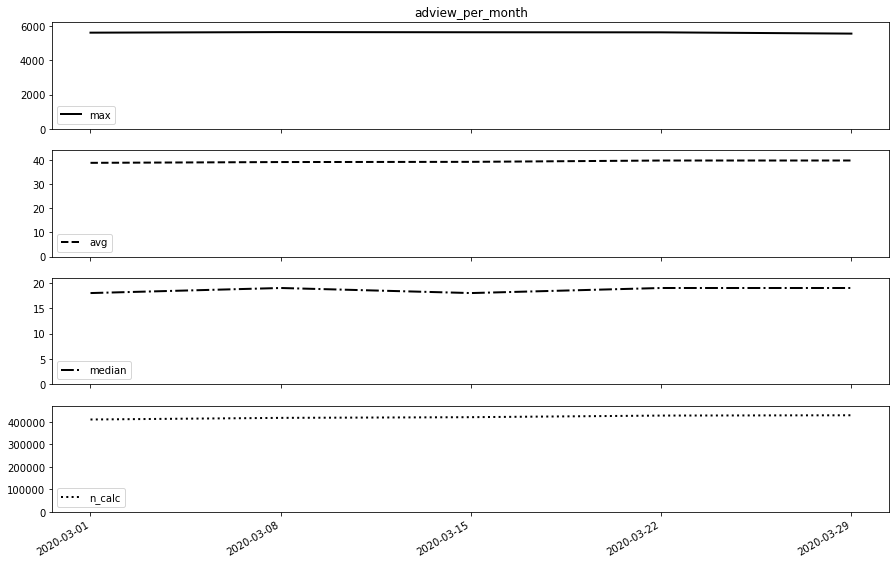

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def metric_qa_plot(qa_data_df, metric_name,**kwargs):
    plt.figure(  figsize=[15,10])
    qa_subplot(qa_data_df,'max',1,None)
    plt.title(metric_name)
    qa_subplot(qa_data_df,'avg',2,'--')
    qa_subplot(qa_data_df,'median',3,'-.')
    qa_subplot(qa_data_df,'n_calc',4,':')
    plt.gca().figure.autofmt_xdate()
    return plt

def qa_subplot(qa_data_df, field, number, linestyle):
    plt.subplot(4, 1, number)
    plt.plot('metric_time', field, data=qa_data_df, marker='', linestyle=linestyle, color='black', linewidth=2, label=field)
    plt.ylim(0, ceil(1.1 * qa_data_df[field].dropna().max()))
    plt.legend()

title="adview_per_month"
#title="adview_per_month"
q_data=session.query(
        Metric.account_id, 
        func.DATE(Metric.metric_time).label("metric_time"),
        MetricName.metric_name,
        Metric.metric_value, 
    )\
    .join(MetricName, MetricName.metric_name_id == Metric.metric_name_id)
#print(pretty_sql(engine, q_data))
data_metric=pd.read_sql(q_data.statement, engine)

# looking to the medians
data_medians_pre=data_metric[["metric_time", "metric_value", "metric_name"]].set_index(["metric_time","metric_name"])
data_medians=data_medians_pre.groupby(["metric_time", "metric_name"]).median()
data_medians=data_medians.rename(columns={"metric_value":"median"})
#only_medians=data_medians[np.in1d(data_medians.index.get_level_values(1), title)]
#print(data_medians)

metricslist=list(metric_stats_over_time["metric_name"].value_counts().index)

data_old=metric_stats_over_time.loc[metric_stats_over_time["metric_name"]==title].set_index(["metric_time", "metric_name"])
data_old=pd.merge(data_old, data_medians, on=["metric_time", "metric_name"])#.set_index(["metric_time"])
data_old=data_old.reset_index(["metric_time"])
metric_qa_plot(data_old, title)



Showing only mean, min and max does not give hints to how the values are distributed.
With a violine chart we would get a better impression of the data.

setting clipping 135.0


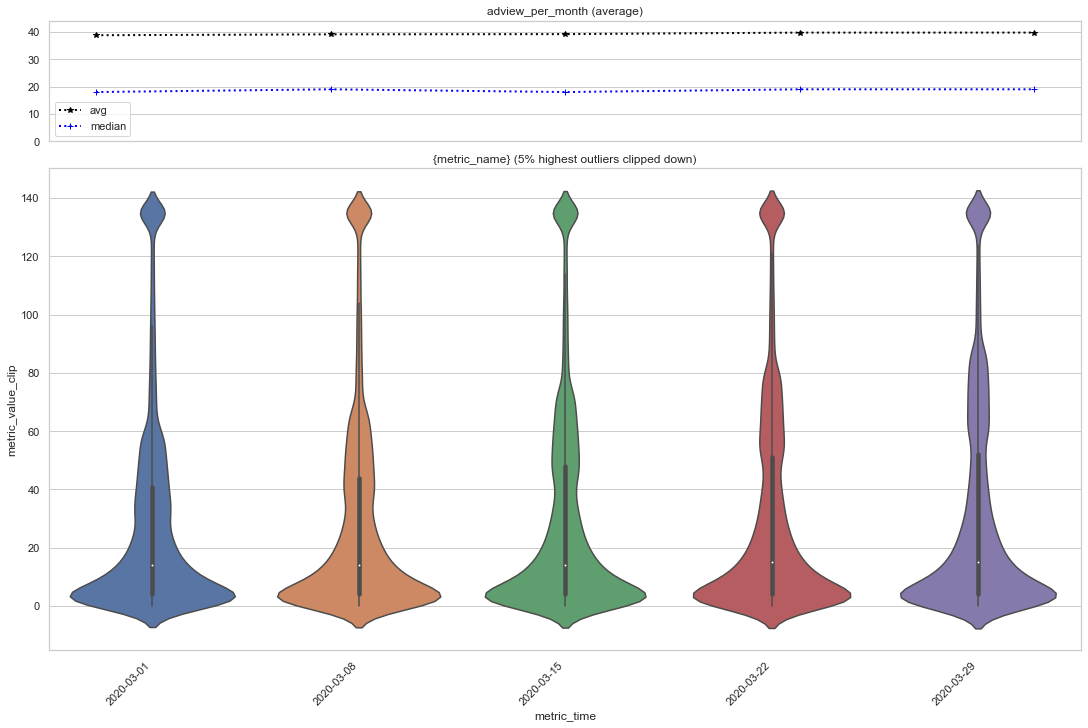

In [8]:
from scipy import stats
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

def metric_qa_violine(qa_data_df, qa_data_df2, alpha, metric_name,**kwargs):
    fig3 = plt.figure(constrained_layout=True, figsize=[15,10])
    gs = fig3.add_gridspec(15, 3)
    f3_ax1 = fig3.add_subplot(gs[3:, :])
    plt.title("{metric_name} (%1d%% highest outliers clipped down)" % ((1-alpha)*100))
    
    qa_sub_violine(qa_data_df,'metric_value_clip',f3_ax1,None)
    f3_ax2 = fig3.add_subplot(gs[:3, :])
    qa_subplot(qa_data_df2,'avg',f3_ax2,':')
    plt.title(f"{metric_name} (average)")
    return plt

def qa_sub_violine(qa_data_df, field, ax1, linestyle):
    ax=sns.violinplot(x="metric_time", y=field, data=qa_data_df, ax=ax1)
    x_dates = qa_data_df["metric_time"].sort_values().unique()
    #x_dates = qa_data_df["metric_time"].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    #ax.legend()

def qa_subplot(qa_data_df, field, ax1, linestyle):
    ret1=ax1.plot("metric_time", 'avg', data=qa_data_df, marker='*', linestyle=linestyle, color='black', linewidth=2, label="avg")
    ret2=ax1.plot("metric_time", 'median', data=qa_data_df, marker='+', linestyle=linestyle, color='blue', linewidth=2, label="median")
    ax1.axis(ymin=0, ymax=ceil(1.1 * qa_data_df[field].dropna().max()))
    ax1.get_xaxis().set_visible(False)
    ax1.legend()


df=data_metric
alpha=0.95
percentiles_arg = df['metric_value'].quantile(alpha)
print(f"setting clipping {percentiles_arg}")
df['metric_value_clip']=df['metric_value'].map(lambda x: min(x, percentiles_arg))



# we reuse the data from the plot above "data_old"
metric_qa_violine(df, data_old, alpha, title)

pass


## metric coverage (§3.8)

In [9]:

from sqlalchemy import distinct, literal, and_, Float, cast

account_count = session.query(func.count(distinct(Subscription.account_id)).label("n_account"))\
    .filter(Subscription.start_date <= d_end_date,
        or_(Subscription.end_date >= d_start_date, Subscription.end_date == None))\
    .cte("account_count")

q_metric_coverage = session.query(MetricName.metric_name,
              func.count(distinct(Metric.account_id)).label("count_with_metric"), 
              account_count.c.n_account,\
              (cast(func.count(distinct(Metric.account_id)),Float) / account_count.c.n_account).label("pcnt_with_metric"),\
              func.avg(Metric.metric_value).label("avg_value"),\
              func.min(Metric.metric_value).label("min_value"),\
              func.max(Metric.metric_value).label("max_value"),\
              func.DATE(func.min(Metric.metric_time)).label("earliest_metric"),\
              func.DATE(func.max(Metric.metric_time)).label("last_metric"))\
        .join(MetricName, Metric.metric_name_id==MetricName.metric_name_id)\
        .join(account_count, literal(True))\
        .join(Subscription, and_(
            Metric.account_id==Subscription.account_id,
            Subscription.start_date <= Metric.metric_time,
            or_(Subscription.end_date >= Metric.metric_time, Subscription.end_date == None)))\
        .filter(Metric.metric_time>=d_start_date, Metric.metric_time<=d_end_date)\
        .group_by(MetricName.metric_name,Metric.metric_name_id, account_count.c.n_account)\
        .order_by(MetricName.metric_name)\
#        .filter(Metric.account_id<100)


metric_coverage = pd.read_sql(q_metric_coverage.statement, engine)
print(metric_coverage)
pass



           metric_name  count_with_metric  n_account  pcnt_with_metric  \
0       account_tenure              11178      11309          0.988416   
1     adview_per_month              11011      11309          0.973649   
2    dislike_per_month              10876      11309          0.961712   
3       like_per_month              11087      11309          0.980370   
4    message_per_month              10992      11309          0.971969   
5  newfriend_per_month              10586      11309          0.936069   
6       post_per_month              11011      11309          0.973649   
7      reply_per_month              10588      11309          0.936245   
8   unfriend_per_month               8826      11309          0.780440   

   avg_value  min_value  max_value earliest_metric last_metric  
0  53.491936        0.0       88.0      2020-03-01  2020-03-29  
1  40.902051        1.0     5635.0      2020-03-01  2020-03-29  
2  16.125132        1.0      608.0      2020-03-01  2020-03-29  

## events per day (§3.9)

In [11]:

from sqlalchemy import Column, Date, Integer, cast

# we need to create a temporary Table containing a sequence of Dates
#drange=pd.to_datetime(pd.date_range(d_start_date, d_end_date, freq="1D").to_list())
#TmpDailyVec=dates_dual({"calc_date":drange}).cte("TmpDailyVec")
TmpDailyVec=dbhelper.days_interval(d_start_date, d_end_date, step=1, label="calc_date").cte("TmpDailyVec")
#print(pretty_sql(engine, session.query(TmpDailyVec)))


# be carefule when using sqlite
# for sqlite you need to use the cast "func.DATE"
#    see reference:
#    https://stackoverflow.com/questions/17333014/convert-selected-datetime-to-date-in-sqlalchemy
events_per_day = session.query(
        Event.event_type_id.label("event_type_id"),
        func.DATE(Event.event_time).label("calc_date"),
        func.count(Event.event_time).label("n_event"))\
    .group_by(Event.event_type_id,"calc_date")\
    .cte("events_per_day")
q_events_per_day = session.query(
        EventType.event_type_name,
        #events_per_day.c.event_type_id,
        TmpDailyVec.c.calc_date.label("event_date"),
        events_per_day.c.n_event
        )\
    .join(events_per_day, func.DATE(TmpDailyVec.c.calc_date)==events_per_day.c.calc_date)\
    .join(EventType, EventType.event_type_id==events_per_day.c.event_type_id)\
    .order_by("event_type_id","event_date") \
    .filter(EventType.event_type_name == "adview")

events_per_day = pd.read_sql(q_events_per_day.statement, engine)
print(events_per_day)

   event_type_name  event_date  n_event
0           adview  2020-03-01    16117
1           adview  2020-03-02    13495
2           adview  2020-03-03    14994
3           adview  2020-03-04    14724
4           adview  2020-03-05    13456
5           adview  2020-03-06    15444
6           adview  2020-03-07    17366
7           adview  2020-03-08    15789
8           adview  2020-03-09    14812
9           adview  2020-03-10    13752
10          adview  2020-03-11    13930
11          adview  2020-03-12    13632
12          adview  2020-03-13    17575
13          adview  2020-03-14    16737
14          adview  2020-03-15    16749
15          adview  2020-03-16    14186
16          adview  2020-03-17    14585
17          adview  2020-03-18    14877
18          adview  2020-03-19    15718
19          adview  2020-03-20    16791
20          adview  2020-03-21    16903
21          adview  2020-03-22    15901
22          adview  2020-03-23    15344
23          adview  2020-03-24    15272


## plotting the events (§3.10)

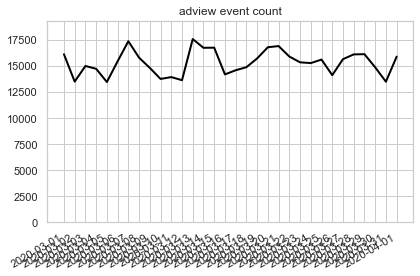

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

def event_count_plot(qa_data_df, event_name,**kwargs):
    #event_data_path = qa_data_path + '_' + event_name + '.csv'
    #qa_data_df=pd.read_csv(event_data_path)
    plt.figure(figsize=(6, 4))
    plt.plot('event_date', 'n_event', data=qa_data_df, marker='', color='black', linewidth=2)
    plt.ylim(0, ceil(1.1 * qa_data_df['n_event'].dropna().max()))
    plt.title('{} event count'.format(event_name))
    plt.gca().figure.autofmt_xdate()
    #plt.xticks(list(filter(lambda x:x.endswith(("01")),qa_data_df['event_date'].tolist())))
    plt.tight_layout()
    #save_to_path=event_data_path.replace('.csv', '_' + event_name + '_event_qa.png')
    #print('Saving metric qa plot to ' + save_to_path)
    #plt.savefig(save_to_path)
    #plt.close()

event_count_plot(events_per_day, "adview")

## events per account (§3.11)

In [13]:

from sqlalchemy import distinct, literal, and_, Float, cast, desc

account_count = session.query(func.count(distinct(Subscription.account_id)).label("n_account"))\
    .filter(Subscription.start_date <= d_end_date,
        or_(Subscription.end_date >= d_start_date, Subscription.end_date == None))\
    .cte("account_count")

n_months=days_between(d_start_date,d_end_date)/28

q_events_per_account = session.query(
        EventType.event_type_name, 
        func.count(Event.event_type_id).label("n_event"),
        account_count.c.n_account,
        (cast(func.count(Event.event_type_id),Float) / account_count.c.n_account).label("events_per_account"),
        literal(n_months).label("n_months"),
        (cast(func.count(Event.event_type_id), Float) / account_count.c.n_account / n_months).label("events_per_account_per_month"))\
    .join(EventType, Event.event_type_id==EventType.event_type_id )\
    .join(account_count, literal(True))\
    .filter(and_(Event.event_time>=d_start_date, Event.event_time<=d_end_date))\
    .group_by(EventType.event_type_name,Event.event_type_id, account_count.c.n_account)\
    .order_by(desc("events_per_account_per_month"))

events_per_account = pd.read_sql(q_events_per_account.statement, engine)
print(events_per_account)
pass


  event_type_name  n_event  n_account  events_per_account  n_months  \
0            like  1133474      11309          100.227606  1.107143   
1         message   676222      11309           59.795031  1.107143   
2            post   494323      11309           43.710584  1.107143   
3          adview   474100      11309           41.922363  1.107143   
4           reply   259839      11309           22.976302  1.107143   
5         dislike   182581      11309           16.144752  1.107143   
6       newfriend    81191      11309            7.179326  1.107143   
7        unfriend    10577      11309            0.935273  1.107143   

   events_per_account_per_month  
0                     90.528161  
1                     54.008415  
2                     39.480528  
3                     37.865360  
4                     20.752789  
5                     14.582357  
6                      6.484553  
7                      0.844763  


## account tenure (§3.12)

In [14]:

from sqlalchemy import and_

d_calc_date=d_end_date

earlier_starts = session.query(Subscription.account_id, func.min(Subscription.start_date).label("start_date"))\
    .filter(Subscription.start_date <= d_calc_date,
        or_(Subscription.end_date > d_calc_date, Subscription.end_date == None))\
    .group_by(Subscription.account_id)\
    .cte(recursive=True, name="earlier_starts")

earlier_starts_L = session.query(Subscription.account_id, Subscription.start_date)\
    .join(earlier_starts, Subscription.account_id == earlier_starts.c.account_id)\
    .filter(and_(Subscription.start_date < earlier_starts.c.start_date,
        Subscription.end_date >= (earlier_starts.c.start_date-31)))

union_all = earlier_starts.union_all(earlier_starts_L)
subq=session.query(union_all).subquery()

# for sqlite we need to use "julianday" do calculate the date diferences
# that's why we make use of a helper function "to_days" being the identity for postgres, 
# but the call of "func.julianday" in sqlite mode
qr=session.query(
        subq.c.account_id, 
        func.min(subq.c.start_date).label("earliest_start"),
        (to_days(d_calc_date)-to_days(func.min(subq.c.start_date))).label("subscriber_tenure_days")
        )\
    .group_by(subq.c.account_id)\
    .order_by("account_id")\
    #.filter(subq.c.account_id<10)
    
account_tenure = pd.read_sql(qr.statement, engine)
print(account_tenure)


       account_id earliest_start  subscriber_tenure_days
0               1     2020-01-05                    87.0
1               4     2020-01-14                    78.0
2               5     2020-01-02                    90.0
3               7     2020-01-08                    84.0
4               8     2020-01-03                    89.0
...           ...            ...                     ...
10567       13170     2020-04-01                     0.0
10568       13197     2020-04-01                     0.0
10569       13265     2020-04-01                     0.0
10570       13287     2020-04-01                     0.0
10571       13306     2020-04-01                     0.0

[10572 rows x 3 columns]


## account tenure insert (§3.13)

In [18]:

from sqlalchemy import literal, select

step=7
subq_days=dbhelper.days_interval(func.Date(to_days(d_start_date)-28), func.Date(to_days(d_end_date)-28), step=step, label="date").subquery()
TmpDaysVec=session.query(
    subq_days.c.date.label("start_date"),
    func.DATE(to_days(subq_days.c.date)+28).label("end_date")
    ).cte("TmpDaysVec")

earlier_starts = session.query(Subscription.account_id, (TmpDaysVec.c.end_date).label("metric_date"), func.min(Subscription.start_date).label("start_date"))\
    .join(TmpDaysVec, and_(Subscription.start_date <= TmpDaysVec.c.end_date,
        or_(Subscription.end_date > TmpDaysVec.c.end_date, Subscription.end_date == None)))\
    .group_by(Subscription.account_id, "metric_date")\
    .cte(recursive=True, name="earlier_starts")

earlier_starts_L = session.query(Subscription.account_id, earlier_starts.c.metric_date, Subscription.start_date)\
    .join(earlier_starts, Subscription.account_id == earlier_starts.c.account_id)\
    .filter(and_(Subscription.start_date < earlier_starts.c.start_date,
        Subscription.end_date >= (earlier_starts.c.start_date-31)))


metric_id=session.query(MetricName.metric_name_id).filter(MetricName.metric_name=="account_tenure").one()[0]

# delete if existing already
session.commit()
old_metrics=session.query(Metric).filter(Metric.metric_name_id==metric_id)
old_metrics.delete()
session.commit()


union_all = earlier_starts.union_all(earlier_starts_L)
subq=session.query(union_all).subquery()
qr=session.query(
        subq.c.account_id,
        subq.c.metric_date.label("metric_time"),
        literal(metric_id).label("metric_name_id"),
        # for postgres we can use this
        #(subq.c.metric_date-func.min(subq.c.start_date)).label("metric_value"),
        # ...but for sqlite we need to use "juliandate"
        (to_days(subq.c.metric_date)
             -to_days(func.min(subq.c.start_date))).label("metric_value"),

    ) \
    .group_by(subq.c.account_id,  subq.c.metric_date)\
    .order_by("account_id",  subq.c.metric_date)

account_tenure = pd.read_sql(qr.statement, engine)
print(account_tenure)

new_metrics_insert=qr.cte("new_metrics_insert")
select_stm=select([new_metrics_insert.c.account_id, new_metrics_insert.c.metric_time, new_metrics_insert.c.metric_name_id, new_metrics_insert.c.metric_value])
target_columns=['account_id', 'metric_time', 'metric_name_id', 'metric_value']
session.execute(Metric.__table__.insert().from_select(target_columns, select_stm))
session.commit()



       account_id metric_time  metric_name_id  metric_value
0               1  2020-03-01               9          56.0
1               1  2020-03-08               9          63.0
2               1  2020-03-15               9          70.0
3               1  2020-03-22               9          77.0
4               1  2020-03-29               9          84.0
...           ...         ...             ...           ...
51722       12098  2020-03-29               9           5.0
51723       12099  2020-03-22               9           6.0
51724       12099  2020-03-29               9          13.0
51725       12100  2020-03-22               9           6.0
51726       12100  2020-03-29               9          13.0

[51727 rows x 4 columns]


## mrr, unit_quantity, billing_period (§§ 3.14/15/16)

In [19]:

from sqlalchemy import func

q_quants = session.query( 
        Subscription.account_id,
        (TmpDaysVec.c.end_date).label("metric_date"),
        func.sum(Subscription.mrr).label("total_mrr"),
        func.sum(Subscription.bill_period_months).label("billing_period"))\
    .join(TmpDaysVec, 
          and_(Subscription.start_date <= TmpDaysVec.c.end_date, 
                or_(Subscription.end_date > TmpDaysVec.c.end_date, Subscription.end_date == None)))\
    .group_by(Subscription.account_id, "metric_date")\
    .order_by(Subscription.account_id, "metric_date")

quants = pd.read_sql(q_quants.statement, engine)
print(quants)

q_quants_unit = session.query( 
        Subscription.account_id,
        (TmpDaysVec.c.end_date).label("metric_date"),
        func.sum(Subscription.quantity).label("total_UNIT"))\
    .join(TmpDaysVec, 
          and_(Subscription.start_date <= TmpDaysVec.c.end_date, 
                or_(Subscription.end_date > TmpDaysVec.c.end_date, Subscription.end_date == None)))\
    .group_by(Subscription.account_id, "metric_date")\
    .order_by(Subscription.account_id, "metric_date")\
    #.filter(Subscription.units == "UNIT")

quants_unit = pd.read_sql(q_quants_unit.statement, engine)
print(quants_unit)


       account_id metric_date  total_mrr  billing_period
0               1  2020-03-01       4.99               1
1               1  2020-03-08       4.99               1
2               1  2020-03-15       4.99               1
3               1  2020-03-22       4.99               1
4               1  2020-03-29       4.99               1
...           ...         ...        ...             ...
51722       12098  2020-03-29      29.99               1
51723       12099  2020-03-22       4.99               1
51724       12099  2020-03-29       4.99               1
51725       12100  2020-03-22       4.99               1
51726       12100  2020-03-29       4.99               1

[51727 rows x 4 columns]
       account_id metric_date total_UNIT
0               1  2020-03-01       None
1               1  2020-03-08       None
2               1  2020-03-15       None
3               1  2020-03-22       None
4               1  2020-03-29       None
...           ...         ...        ...
517